# Navy Data Prep

- compile data with incremental changes
- analyze any potential batch effects
- clean up annotations

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-03-01 17:14:08.506495
Simons Foundation, Rusty HPC, worker3023


In [2]:
%cd /mnt/home/zzhang/ceph/jemm
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


In [3]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jemm import rmats_helper, suppa_helper
from jemm import kallisto_helper
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable

In [4]:
DATA_VER = 'data-V9'
as_types = ['RI', 'A5SS', 'A3SS', 'SE']
enable_rmats_compilation = False
enable_suppa_compilation = False

In [5]:
# prep for junction count measures
rmats_dir = '/mnt/home/zzhang/ceph/My-RNASeq-pipeline/NAVY_CHARM_20200816/rmats'
jct_dict = {}

if enable_rmats_compilation:
    merged_dict = rmats_helper.merge_rmats_runs(
        run1_dir = os.path.join(rmats_dir, 'FOO'),
        run2_dir = os.path.join(rmats_dir, 'FOO_V7'),
        #minimum_sanity_checker = rmats_helper.get_min_sanity_checker(min_avg_count=5, min_avg_psi=0.01, max_avg_psi=0.99),
        as_types = as_types
    )
    if DATA_VER == 'data-V8':
        merged_dict = rmats_helper.merge_rmats_runs(
            run1_dir = os.path.join(rmats_dir, 'FOO_V8'),
            run2_dir = merged_dict,
            #minimum_sanity_checker = rmats_helper.get_min_sanity_checker(min_avg_count=5, min_avg_psi=0.01, max_avg_psi=0.99),
            as_types = as_types
        )
    
    for as_type in as_types:
        save_fp = './%s/compiled/jct_%s.pkl'%(DATA_VER, as_type) if as_type!='SE' else \
            './%s/compiled/jct_%s.txt'% (DATA_VER, as_type)
        if not os.path.isfile(save_fp):
            jct_dict[as_type] = JunctionCountTable.from_darts(
                file=merged_dict[as_type], 
                b1=merged_dict['b1'], 
                b2=merged_dict['b2']
            )
            if as_type != 'SE':
                pickle.dump(jct_dict[as_type], open(save_fp, 'wb'))
            else:
                df = jct_dict[as_type].data.applymap(lambda x: x.to_plaintext())
                df.to_csv(save_fp, sep="\t")

        else:
            print("reload %s" % as_type)
            if as_type != 'SE':
                jct_dict[as_type] = pickle.load(open(save_fp, 'rb'))
            else:
                jct_dict[as_type] = JunctionCountTable.from_plaintext(save_fp)
else:
    print('Skip junction compilation')

Skip junction compilation


In [6]:
if enable_suppa_compilation:
    txr_dict = {}
    for as_type in as_types:
        save_fp = './%s/compiled/txr_%s.pkl'%(DATA_VER,as_type) if as_type!='SE' else \
            './%s/compiled/txr_%s.txt'%(DATA_VER,as_type)
        if not os.path.isfile(save_fp):
            print(as_type)
            txr_dict[as_type] = TranscriptMeasureTable.from_kallisto_hdf5(
                wd="/mnt/home/zzhang/ceph/My-RNASeq-pipeline/NAVY_CHARM_20200816/kallisto/",
                event_type=as_type,
                index_file="/mnt/home/zzhang/ceph/SUPPA/index/hg38/suppa_gencodev34_%s_strict.ioe"%as_type,
                nthreads=12,
                #minimum_sanity_checker=suppa_helper.get_min_sanity_checker(min_avg_psi=0, max_avg_psi=1, max_nan_ratio=0.5)
            )
            if as_type != 'SE':
                pickle.dump(txr_dict[as_type], open(save_fp, 'wb'))
            else:
                df = txr_dict[as_type].data.applymap(lambda x: x.to_plaintext())
                df.to_csv(save_fp, sep="\t")
        else:
            pass
            #if as_type != 'SE':
            #    txr_dict[as_type] = pickle.load(open(save_fp, 'rb'))
            #else:
            #    txr_dict[as_type] = TranscriptMeasureTable.from_plaintext(save_fp)
else:
    print('Skip transcript compilation')

Skip transcript compilation


In [7]:
import pandas as pd
gexp = pd.read_table("%s/All_rsem_tpm.%s.txt" % (DATA_VER, DATA_VER.split('-')[1]) )
gexp.head()

,20_0001-T00_P1,20_0002-T00_P1,20_0070-T00_P1,20_0071-T00_P1,20_0071-T28_P11,20_0072-T00_P1,20_0002-T28_P4,20_0269-T00_P13,20_0497-T35_P13,20_0592-T42_P9,...,MH009-V05_P6,MH009-V06_P6,MH014-V01_P6,MH014-V02_P6,MH014-V03_P6,MH014-V04_P6,MH014-V05_P6,MH015-V01_P6,MH015-V02_P6,MH015-V03_P6
ENSG00000000003.14,4.00,4.0,0.00,6.00,0.00,3.00,3.0,10.00,5.00,0.00,...,5.00,4.00,2.00,1.00,4.00,3.00,1.0,5.0,6.00,10.0
ENSG00000000005.6,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0
ENSG00000000419.12,241.00,207.0,230.00,301.00,244.00,223.00,245.0,274.00,364.00,280.00,...,284.00,317.00,246.00,222.00,227.00,230.00,227.0,271.0,276.00,277.0
ENSG00000000457.14,333.25,286.3,223.93,267.44,287.93,260.96,334.3,408.75,460.95,322.48,...,263.05,290.67,365.97,285.93,372.35,294.21,290.5,416.7,441.68,426.1
ENSG00000000460.17,21.75,32.7,44.07,56.56,42.07,32.04,49.7,46.25,62.05,57.52,...,50.95,52.33,82.03,26.07,94.65,69.79,71.5,41.3,68.32,62.9


In [8]:
from collections import defaultdict
sid_to_col = defaultdict(list)
for c in gexp.columns:
    sid = "_".join(c.split("_")[0:2])
    sid_to_col[sid].append(c)

print(len(sid_to_col))
print(sid_to_col['20_0033-T00'])

1365
['20_0033-T00_P1']


In [9]:
pooled_exp = {}
for sid in sid_to_col:
    pooled_exp[sid] = gexp[sid_to_col[sid]].mean(axis=1)

pooled_exp_df = pd.DataFrame.from_dict(pooled_exp)
pooled_exp_df.head()

,20_0001-T00,20_0002-T00,20_0070-T00,20_0071-T00,20_0071-T28,20_0072-T00,20_0002-T28,20_0269-T00,20_0497-T35,20_0592-T42,...,MH009-V05_P6,MH009-V06_P6,MH014-V01_P6,MH014-V02_P6,MH014-V03_P6,MH014-V04_P6,MH014-V05_P6,MH015-V01_P6,MH015-V02_P6,MH015-V03_P6
ENSG00000000003.14,4.00,4.0,0.00,6.00,0.00,3.00,3.0,9.000,6.500,0.00,...,5.00,4.00,2.00,1.00,4.00,3.00,1.0,5.0,6.00,10.0
ENSG00000000005.6,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0
ENSG00000000419.12,241.00,207.0,230.00,301.00,244.00,223.00,245.0,228.500,303.000,280.00,...,284.00,317.00,246.00,222.00,227.00,230.00,227.0,271.0,276.00,277.0
ENSG00000000457.14,333.25,286.3,223.93,267.44,287.93,260.96,334.3,323.315,452.015,322.48,...,263.05,290.67,365.97,285.93,372.35,294.21,290.5,416.7,441.68,426.1
ENSG00000000460.17,21.75,32.7,44.07,56.56,42.07,32.04,49.7,26.185,55.985,57.52,...,50.95,52.33,82.03,26.07,94.65,69.79,71.5,41.3,68.32,62.9


In [ ]:
meta = pd.read_csv("%s/charm_master.csv" % DATA_VER, sep="\t" if DATA_VER=='data-V8' else ",")
meta['IgG_call'] =  [x.split('|')[-1] if type(x) is str else "Unknown" for x in meta['IgG_call']]
meta['IgM_call'] =  [x.split('|')[-1] if type(x) is str else "Unknown" for x in meta['IgM_call']]
meta = meta.rename(columns={'RNAseq_plate': 'plateNum'})
meta['plateNum'] = meta['plateNum'].str.replace('?', '')

meta = meta.drop_duplicates().set_index('sid')
meta = meta.loc[meta.index.isin(pooled_exp_df.columns)]
meta = meta.loc[~meta.final.isnull()]
meta = meta.loc[~meta.Sex.isnull()]
meta = meta.loc[~meta['plateNum'].isnull()]
meta = meta.loc[~meta['final'].isin(['Unclear', 'Pending', 'Late'])]

meta['plateNum'] = ['Multiple' if ';' in x else x for x in meta['plateNum']]

meta = meta.dropna(axis=1)
#meta = meta.loc[meta.index.isin(gexp.columns)]
meta['final'].replace({'First_Mid': 'First'}, inplace=True)
meta['final'].replace({'Immune +': 'Immune'}, inplace=True)


# remove outliers; retrospective analyses from PCA
#black_list_sids = ['20_1811-T49', '20_0246-T00', '20_3381-T00']
#meta = meta.loc[~meta.index.isin(black_list_sids)]
print(meta.shape)
print(meta['plateNum'].value_counts())
print(meta['final'].value_counts())

meta.to_csv("%s/charm_master.clean.csv"%DATA_VER)
meta.head()

## Get the batch effect using RNA-seq data

## 1. Read in and Clean up the data

Will do the following:
- read in gene expression (RSEM) matrix and pool the plates by average
- intersect meta data with RNA-seq samples, because some entries in metadata does not have RNA-seq

In [11]:
from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

data_files = {
    'SE': {
        'jct': './%s/compiled/jct_SE.txt' % DATA_VER,
        'txr': './%s/compiled/txr_SE.txt' % DATA_VER
    }, 
    'A5SS': {
        'jct': './%s/compiled/jct_A5SS.pkl' % DATA_VER,
        'txr': './%s/compiled/txr_A5SS.pkl' % DATA_VER
    }, 
    'A3SS': {
        'jct': './%s/compiled/jct_A3SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A3SS.pkl'% DATA_VER
    }, 
    'RI': {
        'jct': './%s/compiled/jct_RI.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_RI.pkl'% DATA_VER
    }
}

contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post',
    'Asymptomatic',
    'Mild',
    'Moderate',
    'Exposed',
    'False Negative',     
    'Immune',              
    'Reinfection'
])
covs = Covariate(
                 fp="./%s/charm_master.clean.csv" % DATA_VER, 
                 sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
                 factor_conversion={
                     'final': {
                         'Asymptomatic': 'final@Asymptomatic',
                         'Exposed': 'final@Exposed',
                         'False Negative': 'final@False Negative',
                         'First': 'final@First',
                         'Immune': 'final@Immune',
                         'Mid': 'final@Mid',
                         'Mild': 'final@Mild',
                         'Moderate': 'final@Moderate',
                         'Post': 'final@Post',
                         'Pre': 'final@Pre',
                         'Reinfection': 'final@Reinfection'
                     },
                     'Sex': {'M': 'Sex@M'}
                 },
                 verbose=True
             )

metaloader = MetaLoader(covariates=covs, data_files=data_files, reg_tables=None,
                       jem_kwargs={'diff_intercept_by_measure':True},
                       verbose=True)

loading SE..
loaded n=(9210, 1176) jct, n=(9210, 1176) txr
loading A5SS..
loaded n=(1684, 1176) jct, n=(1684, 1176) txr
loading A3SS..
loaded n=(2930, 1176) jct, n=(2930, 1176) txr
loading RI..
loaded n=(2945, 1176) jct, n=(2945, 1176) txr


In [12]:
contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post',
    'Asymptomatic',
    'Mild',
    'Moderate',
    'Exposed',
    'False Negative',     
    'Immune',              
    'Reinfection'
])
covs = Covariate(
                 fp="./%s/charm_master.clean.csv" % DATA_VER, 
                 sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
                 factor_conversion={
                     'final': {
                         'Asymptomatic': 'final@Asymptomatic',
                         'Exposed': 'final@Exposed',
                         'False Negative': 'final@False Negative',
                         'First': 'final@First',
                         'Immune': 'final@Immune',
                         'Mid': 'final@Mid',
                         'Mild': 'final@Mild',
                         'Moderate': 'final@Moderate',
                         'Post': 'final@Post',
                         'Pre': 'final@Pre',
                         'Reinfection': 'final@Reinfection'
                     },
                     'Sex': {'M': 'Sex@M'}
                 },
                 verbose=True
             )
covs.meta.shape

(1176, 11)

In [13]:
pooled_exp_df = pooled_exp_df[[x for x in meta.index if x in pooled_exp_df]]
#pooled_exp_df = pooled_exp_df[meta.index]
pooled_exp_df.to_csv("./%s/matrix/All_rsem.gene.tpm_pooled_plate.txt"%DATA_VER)
pooled_exp_df.head()

,20_0001-T00,20_0002-T00,20_0002-T28,20_0003-T00,20_0003-T28,20_0004-T00,20_0005-T00,20_0005-T28,20_0006-T00,20_0006-T28,...,20_2485-T49,20_2485-T63,20_2505-T10,20_2505-T14,20_2505-T17,20_2512-T00,20_2512-T35,20_2512-T39,20_2512-T42,20_2512-T49
ENSG00000000003.14,4.00,4.0,3.0,0.00,4.0,2.25000,17.50,1.00,3.00,6.00,...,0.0,0.00,0.00,0.00,14.00,0.0,6.00,1.00,12.0,0.00
ENSG00000000005.6,0.00,0.0,0.0,0.00,0.0,0.00000,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
ENSG00000000419.12,241.00,207.0,245.0,169.00,225.0,214.87500,174.50,258.00,283.00,188.00,...,270.0,219.00,212.00,228.00,289.00,258.0,459.00,425.00,335.0,305.00
ENSG00000000457.14,333.25,286.3,334.3,311.48,353.1,209.53125,356.72,407.11,500.04,335.14,...,226.0,379.65,285.96,313.03,301.88,262.0,437.91,463.45,290.0,201.55
ENSG00000000460.17,21.75,32.7,49.7,41.52,52.9,34.34375,39.28,58.89,34.96,40.86,...,38.0,11.35,42.04,39.97,44.12,2.0,60.09,62.55,10.0,161.45


In [14]:
jct_dfs = {}
txr_dfs = {}
for as_type in metaloader.data:
    print(as_type)
    df1 = metaloader.data[as_type].junction_measure.applymap(lambda x: x.psi if pd.notna(x) else None)[meta.index]
    df1.to_csv("./%s/matrix/%s-JCT.txt"%(DATA_VER, as_type), sep="\t")
    jct_dfs[as_type] = df1
    df2 = metaloader.data[as_type].transcript_measure.applymap(lambda x: x.psi if pd.notna(x) else None)[meta.index]
    df2.to_csv("./%s/matrix/%s-TXR.txt"%(DATA_VER, as_type), sep="\t")
    txr_dfs[as_type] = df2

SE
A5SS
A3SS
RI


## 2. Demonstration of plate-wise annotation distribution

In [15]:
import pandas as pd
from jemm.covariate import Contrasts, Covariate
contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post'
    'Asymptomatic',
    'Mild',
    'Moderate',
    'Exposed',
    'Immune',
    'False Negative',     
    'Reinfection',         
])
covs = Covariate(fp="./%s/charm_master.clean.csv" % DATA_VER, sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
             )
meta_ = pd.read_csv("./%s/charm_master.clean.csv" % DATA_VER, index_col=0)
meta_ = meta_.loc[covs.covariate.index]
plate_annot = meta_.groupby(['plateNum', 'final']).size().unstack(fill_value=0)
plate_annot.head()

final,Control,Exposed,False Negative,First,Immune,Mid,Mild,Moderate,Pre,Reinfection
plateNum,,,,,,,,,,
Multiple,32,14,2,17,16,30,9,10,15,2
P1,0,6,0,0,0,0,15,11,0,0
P10,24,0,3,3,1,27,0,0,1,0
P11,0,12,0,0,0,0,19,13,0,0
P12,1,0,0,0,0,0,0,0,0,0


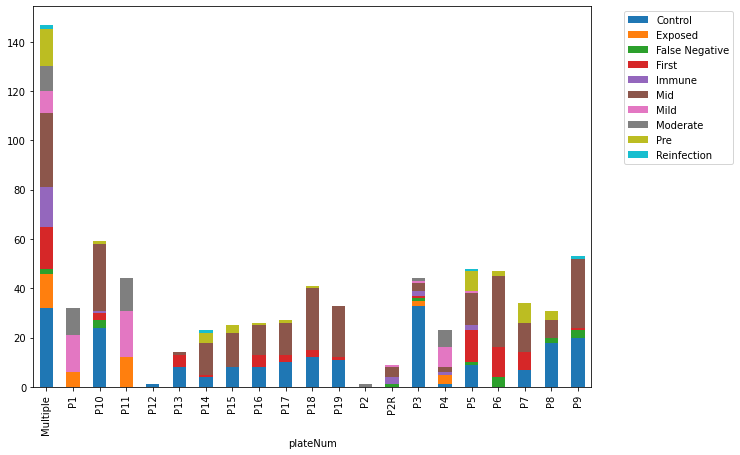

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(10,7))
plate_annot.plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 3. Perform scaling and  PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
pca = PCA(n_components=10, random_state=777)
# scale each gene to Z-score
scaled_df = scale(pooled_exp_df, axis=1)
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=777,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
np.var(scaled_df[100,:])

1.0000000000000007

In [19]:
print(pca.explained_variance_ratio_)

[0.10434525 0.02931321 0.02211398 0.01531362 0.01010172 0.00721295
 0.00616487 0.00549828 0.00514527 0.00440878]


In [20]:
pca.components_.shape

(10, 1176)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

col_mapper = {
    'final': {'Late':'red', 'Control':'green'},
    'IgG_call': {'Pos':'orange', 'Neg':'white'},
    'Sex': {'F':'red', 'M':'blue'},
    'tp': {0:'pink', 28:'red'},
    'plateNum': {'P1':'darkgreen', 'P3': 'red', 'P4':'orange', 'P5':'yellow', 'P6':'green', 'P7':'blue', 'P8':'purple'}
}

Text(0, 0.5, 'PC2, 0.029')

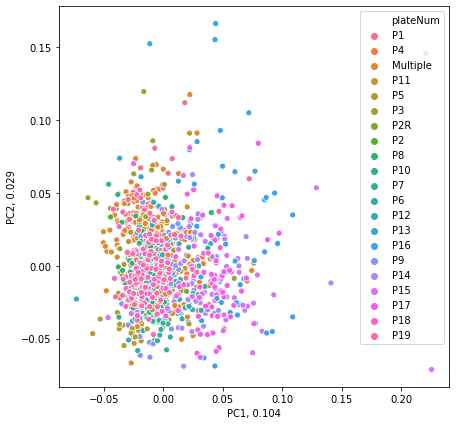

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'plateNum'], ax=ax)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
#ax.get_legend().remove()

In [23]:
# remove outlier
#print(np.where(pca.components_[1]>0.3)) # 512  ## 1007
#pooled_exp_df.iloc[:, [1007, 1058]] # 20_0246-T00 ## 20_1811-T49

Text(0, 0.5, 'PC2, 0.029')

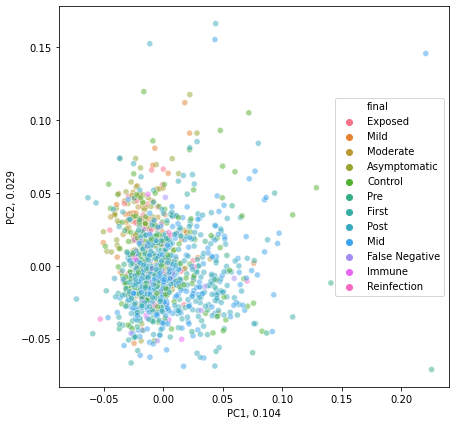

In [24]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'final'], ax=ax, alpha=0.5)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])

Text(0, 0.5, 'PC2, 0.029')

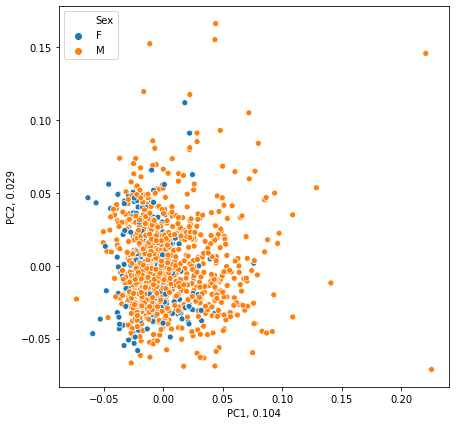

In [25]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'Sex'], ax=ax)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])

## PCA on all AS types

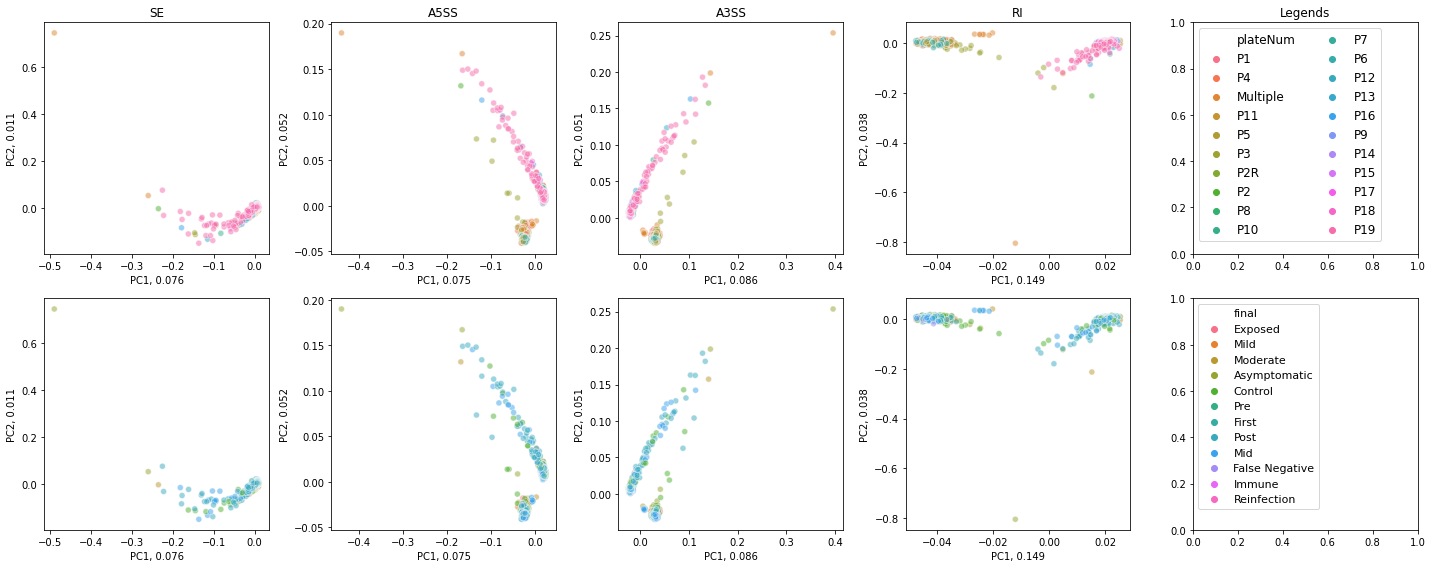

In [26]:
# jct
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
i = 0
for as_type in jct_dfs:
    pca = PCA(n_components=10, random_state=777)
    pca.fit(scale(jct_dfs[as_type].fillna(jct_dfs[as_type].mean(axis=0)).fillna(0.5), axis=1))
    # plate
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['plateNum'], alpha=0.5, ax=axs[0, i])
    axs[0, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[0, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[0, i].set_title(as_type)
    axs[0, i].get_legend().remove()
    # condition
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['final'], alpha=0.5, ax=axs[1, i])
    axs[1, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[1, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[1, i].get_legend().remove()

    i+=1
axs[0,i].legend(*axs[0,i-1].get_legend_handles_labels(), loc='upper left', fontsize=12, ncol=2)
axs[1,i].legend(*axs[1,i-1].get_legend_handles_labels(), loc='upper left', fontsize=11, ncol=1)
axs[0,i].set_title('Legends')


fig.tight_layout()

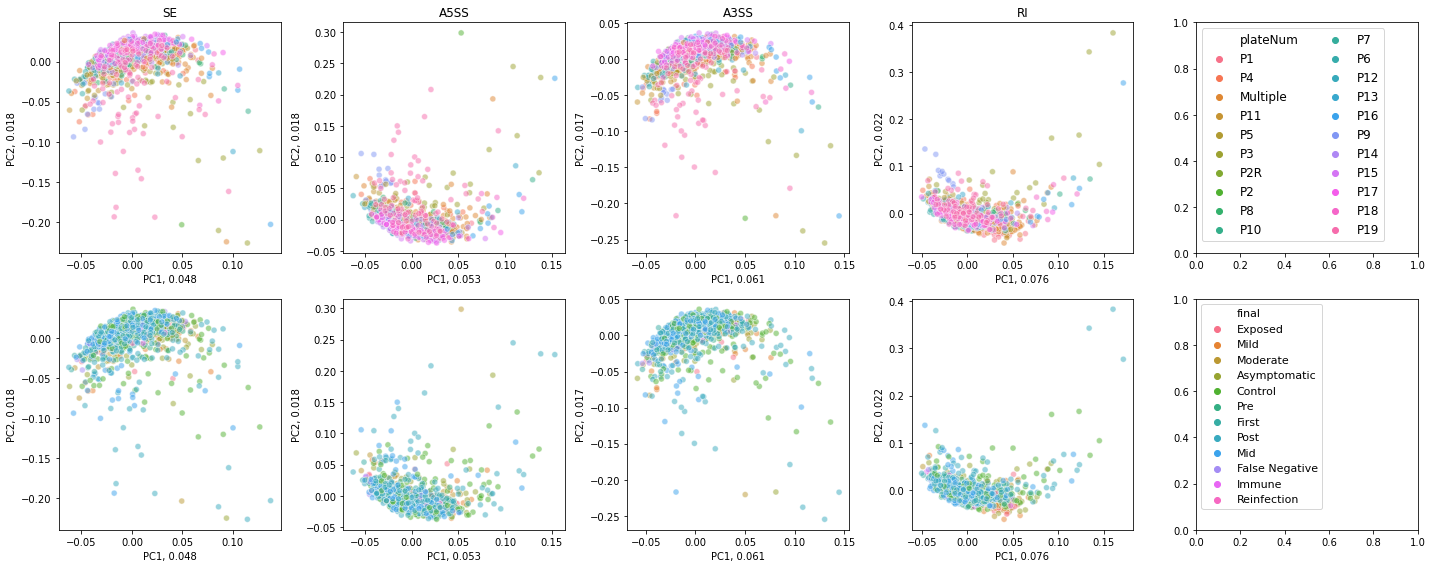

In [27]:
# txr
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
i = 0
for as_type in txr_dfs:
    pca = PCA(n_components=10, random_state=777)
    pca.fit(scale(txr_dfs[as_type].fillna(txr_dfs[as_type].mean(axis=0)).fillna(0.5), axis=1))
    # plate
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['plateNum'], alpha=0.5, ax=axs[0, i])
    axs[0, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[0, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[0, i].set_title(as_type)
    axs[0, i].get_legend().remove()
    # condition
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['final'], alpha=0.5, ax=axs[1, i])
    axs[1, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[1, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[1, i].get_legend().remove()

    i+=1
axs[0,i].legend(*axs[0,i-1].get_legend_handles_labels(), loc='upper left', fontsize=12, ncol=2)
axs[1,i].legend(*axs[1,i-1].get_legend_handles_labels(), loc='upper left', fontsize=11, ncol=1)
fig.tight_layout()

## 4. Write new metadata with top PCs

In [28]:
import scipy.stats as ss
print(meta.shape)
pca = PCA(n_components=20, random_state=777)
pca.fit(scale(txr_dfs['SE'].fillna(txr_dfs['SE'].mean(axis=0)).fillna(0.5), axis=1))
pcs = []
for i in range(len(pca.components_)):
    meta["PC%i"%i] = pca.components_[i]
    sp = ss.spearmanr(pca.components_[i], meta['final'])
    sp2 = ss.spearmanr(pca.components_[i], meta['Sex'])
    sp3 = ss.spearmanr(pca.components_[i], meta['Age'])
    sp4 = ss.spearmanr(pca.components_[i], meta['tp'])

    print('PC%i, Final Spearman=%.3f, pval=%.3f' % (i, sp.correlation, sp.pvalue))
    print('      Sex   Spearman=%.3f, pval=%.3f' % (sp2.correlation, sp2.pvalue))
    print('      Age   Spearman=%.3f, pval=%.3f' % (sp3.correlation, sp3.pvalue))
    print('      TP    Spearman=%.3f, pval=%.3f' % (sp4.correlation, sp4.pvalue))
    if sp.pvalue > 0.01 and sp2.pvalue > 0.01 and sp3.pvalue > 0.01:
        pcs.append(i)
print('PCs w/o strong corr.: %s' % pcs)

(1176, 11)
PC0, Final Spearman=-0.021, pval=0.480
      Sex   Spearman=0.042, pval=0.150
      Age   Spearman=0.022, pval=0.457
      TP    Spearman=-0.106, pval=0.000
PC1, Final Spearman=0.074, pval=0.011
      Sex   Spearman=0.085, pval=0.004
      Age   Spearman=-0.042, pval=0.151
      TP    Spearman=0.124, pval=0.000
PC2, Final Spearman=-0.009, pval=0.753
      Sex   Spearman=0.202, pval=0.000
      Age   Spearman=-0.065, pval=0.025
      TP    Spearman=0.113, pval=0.000
PC3, Final Spearman=-0.256, pval=0.000
      Sex   Spearman=-0.128, pval=0.000
      Age   Spearman=0.211, pval=0.000
      TP    Spearman=-0.340, pval=0.000
PC4, Final Spearman=0.152, pval=0.000
      Sex   Spearman=-0.106, pval=0.000
      Age   Spearman=0.001, pval=0.972
      TP    Spearman=0.027, pval=0.361
PC5, Final Spearman=0.158, pval=0.000
      Sex   Spearman=-0.035, pval=0.232
      Age   Spearman=0.001, pval=0.979
      TP    Spearman=-0.015, pval=0.610
PC6, Final Spearman=0.037, pval=0.206
      Sex 

In [30]:
print("FINISH:", datetime.now())

FINISH: 2021-03-01 17:26:42.750921
